## Bias-Variance Trade-off and Decomposition

One of the critical concepts in data science is the **bias-variance** trade-off. This expresses how certain hyper-parameters affect the error of a model, and how the best model is achieved by finding the minimum error.

The error is often decomposed into **bias** and **variance**. These are theoretical concepts. To calculate bias and variance we need to understand the population, so we can't measure the bias or variance from a sample.

This notebook is an exploration of bias and variance of various models, on a simple fake dataset with one feature.

$\DeclareMathOperator{\E}{\mathbb{E}}$
$\DeclareMathOperator{\Bias}{Bias}$
$\DeclareMathOperator{\Var}{Var}$

Suppose there is some underlying true function $f(x)$, such that $y = f(x) + \epsilon$, where the noise $\epsilon$ has a mean of zero and standard deviation of $\sigma$. We've created some function $\hat f(x)$ to estimate $y$, and want the residuals $|y - \hat f(x)|$ to be as small as possible. We can decompose this into three parts: the  square of the **bias**, the **variance**, and the **irreducible error**.

These are independent, so the some of these (as squares) is equal to the square of the total error.

$$\E\left[(y - \hat f(x))^2\right] = \left(\Bias[\hat f(x)]\right)^2 + \Var[\hat f(x)] + \sigma^2$$

where
$$\Bias[\hat f(x)] = \E[\hat f(x)] - f(x)$$
and
$$\text{Var}[\hat f(x)] = \E[\hat f(x)^2] - \E[\hat f(x)]^2$$


TBD: add derivation.

$$
\begin{align}
\E\left[(y - \hat f(x))^2\right] & = \E\left[(f(x) + \epsilon -
     \hat f(x) +
     \E[\hat f(x)] - \E[\hat f(x)
     )^2\right] \\
     & = 
\end{align}$$

Let's show an example, following the notation above. For our fake dataset, we take $\sigma$ to be 1, the irreducible error to be normally distributed, and $f(x)$ to be a cosine.

In [93]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures

from sklearn.pipeline import Pipeline

#from tensorflow import keras

In [94]:
sigma = 1

def f(x):
    return np.cos(x)

def epsilon(x):
    return stats.norm(0, sigma).rvs(x.shape)

def y(x):
    return f(x) + epsilon(x)

Now we'll look at it in some range, say, 0 to 15.

In [95]:
xlim = (0, 15)
n_pts = 100
xpts = np.linspace(*xlim, n_pts)
ypts = f(xpts)

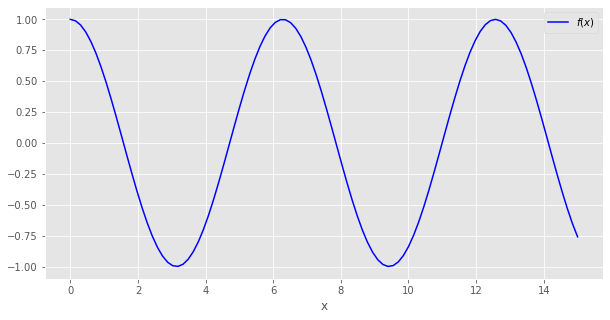

In [96]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(xpts, ypts, 'b-', label='$f(x)$')
ax.legend()
ax.set_xlabel('x');

Now we'll choose a training sample and fit a model to those data. We'll start with a kNN regressor, first with `k=3`.

In [97]:
y_sample = y(x_sample)
model = KNeighborsRegressor(3)
model.fit(x_sample[:, None], y_sample)

KNeighborsRegressor(n_neighbors=3)

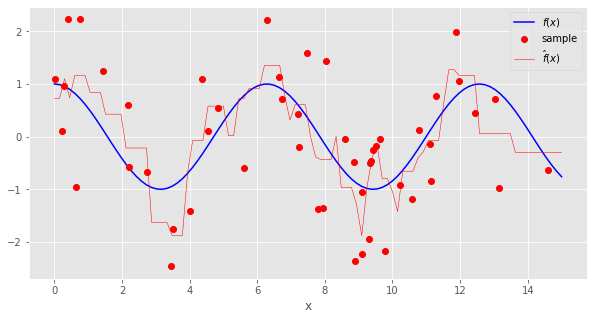

In [98]:
points = ax.plot(x_sample, y_sample, 'ro', label='sample')
ax.plot(xpts, model.predict(xpts[:, None]), 'r-', lw=0.5, label='$\hat{f}(x)$')
ax.legend()
fig

So: $f(x)$ is the underlying function, $f^(x)$ is values predicted from the model build with the sample some training sample.

Let's look at the values of  $f^(x)$ over a whole bunch of samples, and the average of all of those  $\E[\hat f(x)]$.

First, we'll create a class to handle this.

In [196]:
class BiasVarianceRenderer:
    
    def __init__(self, npts):
        self.n_pts = n_pts
    
    def generate_f(self, f, xlim):
        self.f = f
        self.xlim = xlim
        self.xpts = np.linspace(*xlim, self.n_pts)
        self.ypts = f(xpts)
        self.predictions_to_plot = 50  # don't plot predictions from every sample or it's too noisy

    def generate_samples(self, sample_size, n_trials):
        # generate a bunch of samples from the distributions along with the actual values
        self.sample_size = sample_size
        self.n_trials = n_trials
        self.x_samples = stats.uniform(self.xlim[0],
                                       self.xlim[1]-self.xlim[0]).rvs((self.sample_size,
                                                                       self.n_trials))
        self.y_samples = np.zeros_like(self.x_samples)
        # we could do this without the loop but the meaning is less clear
        for t in range(self.n_trials):
            self.y_samples[:, t] = y(self.x_samples[:, t])

    def plot_panel_pair(self, ax1, ax2, model, label):
        predictions = np.zeros((self.n_trials, self.n_pts))
        for t in range(self.n_trials):
            x_sample = self.x_samples[:, t]
            y_sample = self.y_samples[:, t]
            model.fit(x_sample[:, None],
                      y_sample)
            predictions[t, :] = model.predict(self.xpts[:, None])
            if t < self.predictions_to_plot:
                ax1.plot(self.xpts,
                         predictions[t,:], 'r-', lw=0.1)

        ax1.plot(self.xpts, self.ypts, 'b-', label='$f(x)$')
        ax1.plot(self.xpts, predictions.mean(axis=0), color='#AA0000', lw=3, label="$E[\hat f(x)]$")

        ax1.set_ylim((-2, 2)) # don't hard-code this
        ax1.set_title(label)
        ax1.legend()
        #ax[1].plot(xpts, predictions.mean(axis=0) - ypts, 'k', label='bias')
        bias = predictions.mean(axis=0) - ypts
        variance = predictions.var(axis=0)
        error = ((predictions - ypts)**2).mean(axis=0)
        ax2.plot(self.xpts, bias**2, 'k', label=r'$\mathrm{bias}^2$')
        ax2.plot(self.xpts, variance, 'r', label='variance')
        ax2.plot(self.xpts, bias**2 + variance, 'g', label=r'$\mathrm{bias}^2$ + variance')
        ax2.plot(self.xpts, error**2, 'b', label=r'\mathrm{total}^2')
        ax2.plot(self.xpts, np.zeros_like(self.xpts), 'k', lw=0.5)
        ax2.axhline(np.mean(bias**2 + variance), color='g', ls=':', label='average total')

        ax2.legend()

    def plot(self, fig, base_model, values, label):
        for i, value in enumerate(values, start=1):
            model = base_model(value)
            #print(values, i)
            if i == 0:
                ax1 = fig.add_subplot(2, len(values), i, sharey='row', sharex='all')
            else:
                ax1 = fig.add_subplot(2, len(values), i)
            ax2 = fig.add_subplot(2, len(values), i + len(values))
            self.plot_panel_pair(ax1, ax2,
                                 model=model,
                                 label=label.format(value))
        

Now we can generate specify a function and generate a large number of samples from it.

In [197]:
bvr = BiasVarianceRenderer(npts=100)
bvr.generate_f(f, (0, 15))
bvr.generate_samples(sample_size=50, n_trials=200)

Next, we look at the bias and variance for various values of the hyperparameter k using a **k-nearest-neighbors regressor**.

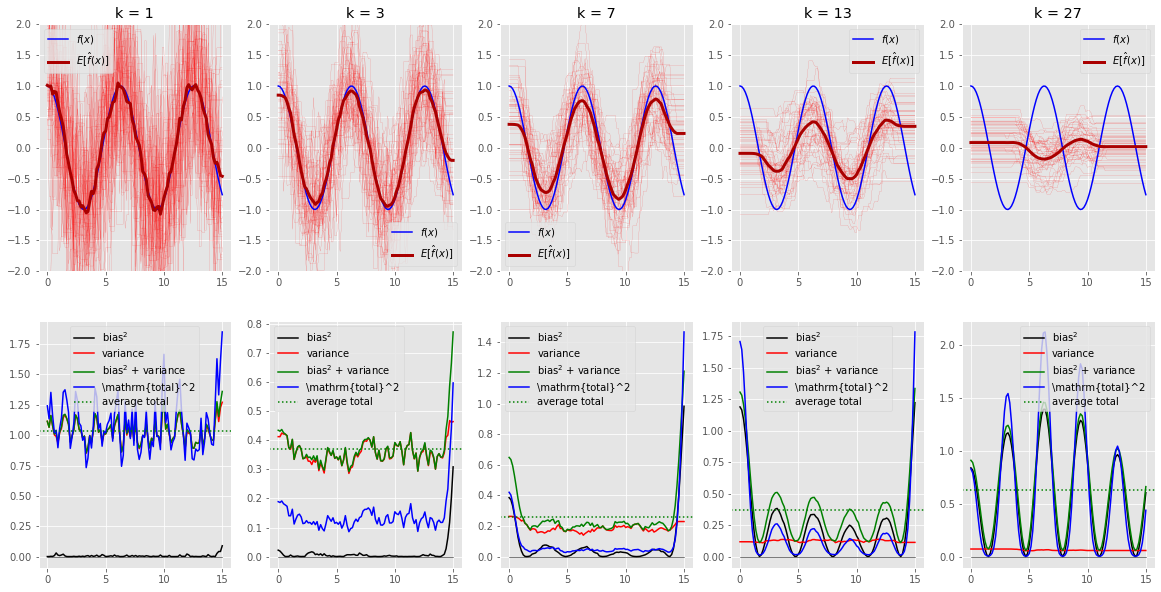

In [198]:
fig = plt.figure(figsize=(20,10))

bvr.plot(fig=fig,
         base_model=KNeighborsRegressor,
         values=(1, 3, 7, 13, 27),
         label="k = {}")

N.B. Although the bias when $k=1$ does not seen to be $0$, that's because we only have a finite number of samples. If we increase it enough it will converge.

Let's try the same thing with **Decision Trees**

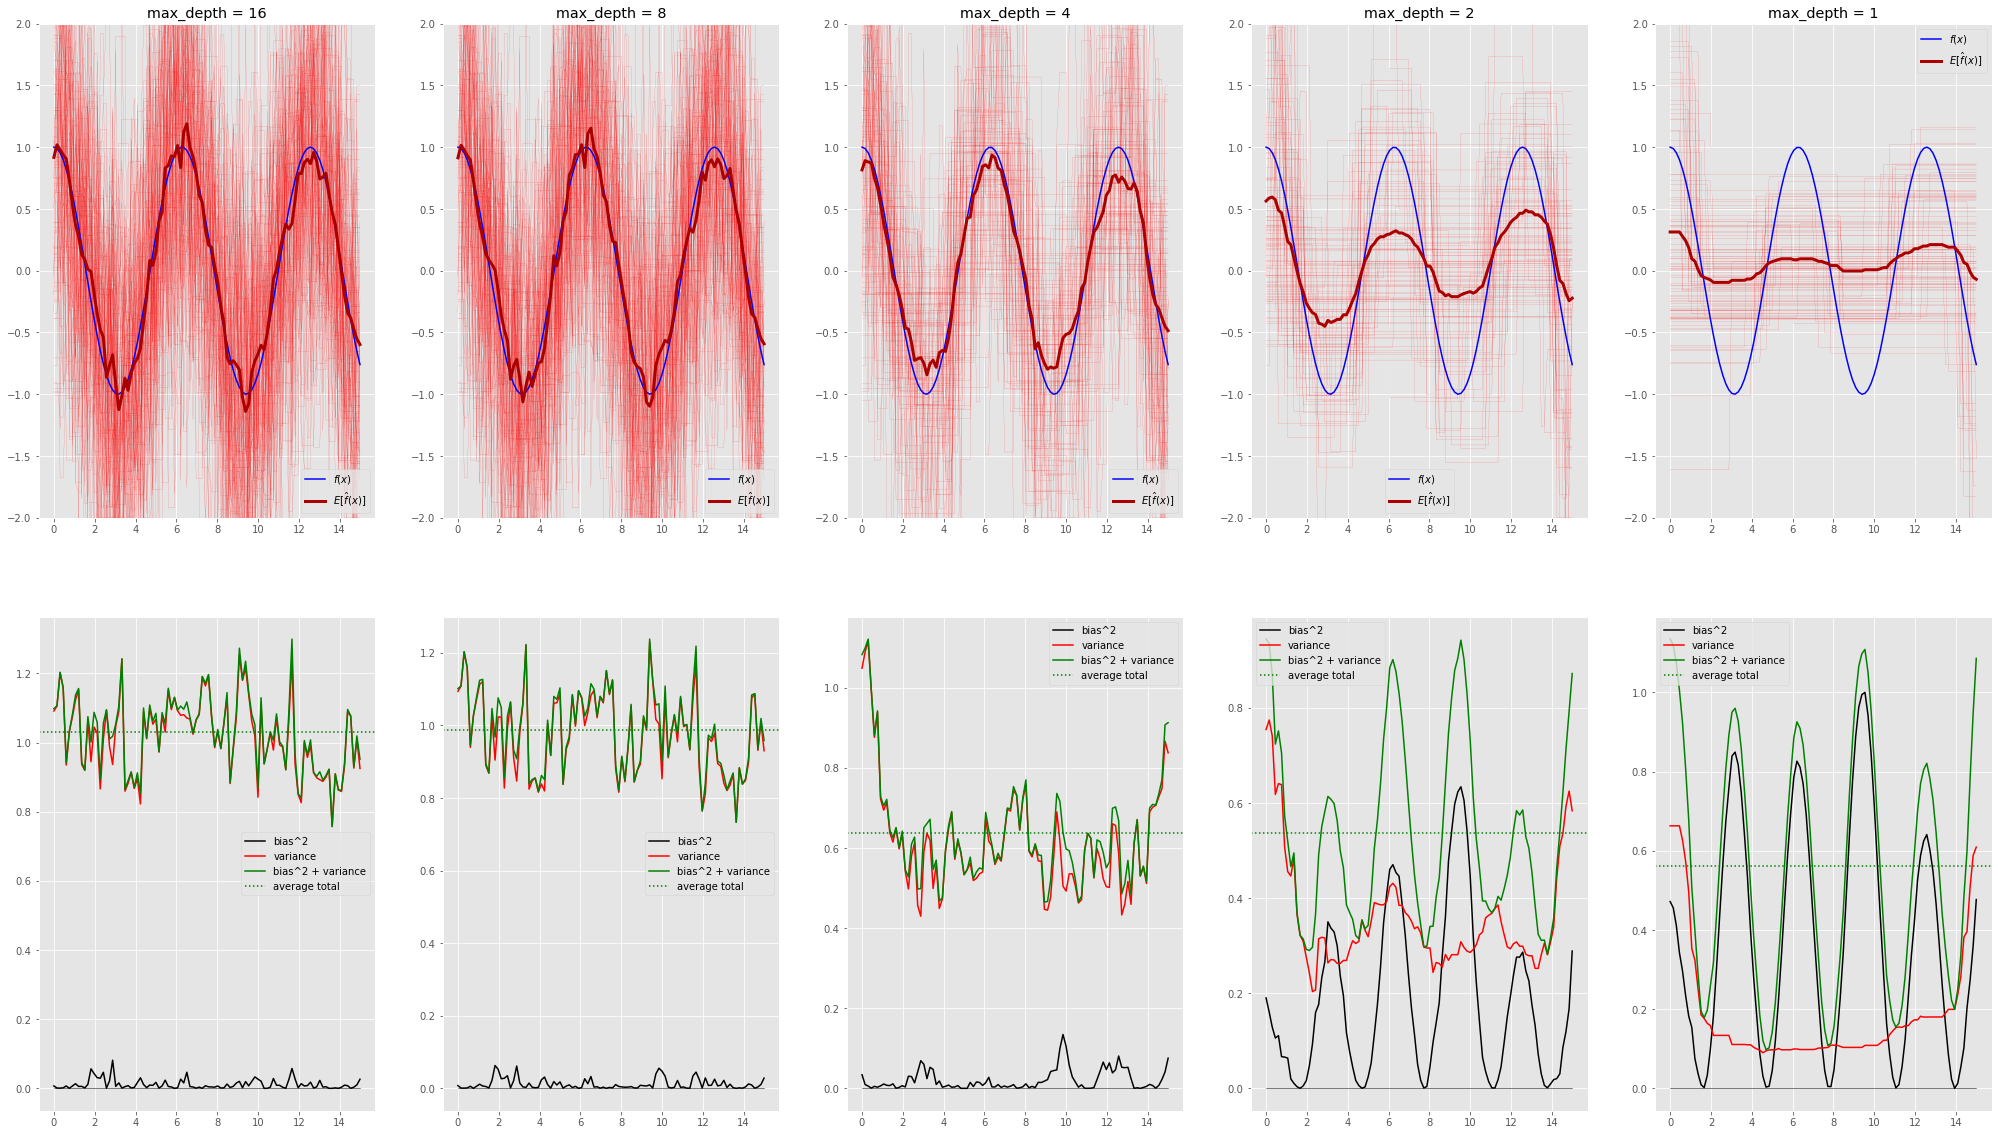

In [150]:
fig = plt.figure(figsize=(20, 10))

bvr.plot(fig=fig,
         base_model=lambda k: DecisionTreeRegressor(max_depth=k),
         values=(16, 8, 4, 2, 1),
         label="max_depth = {}")

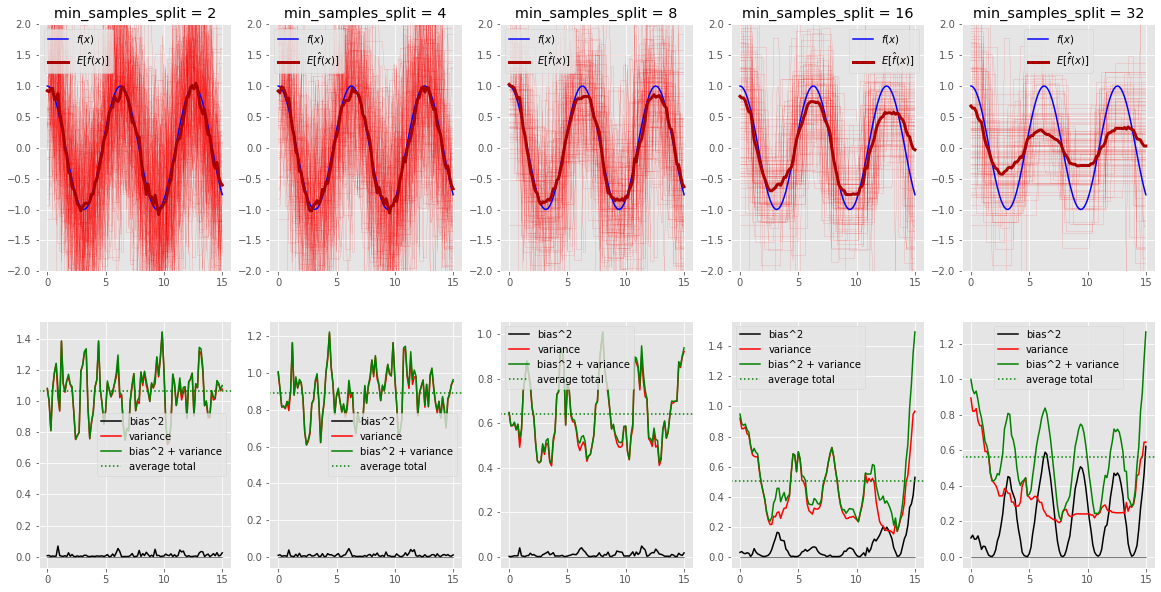

In [154]:
fig = plt.figure(figsize=(20, 10))

bvr.plot(fig=fig,
         base_model=lambda k: DecisionTreeRegressor(min_samples_split=k),
         values=(2, 4, 8, 16, 32),
         label="min_samples_split = {}")

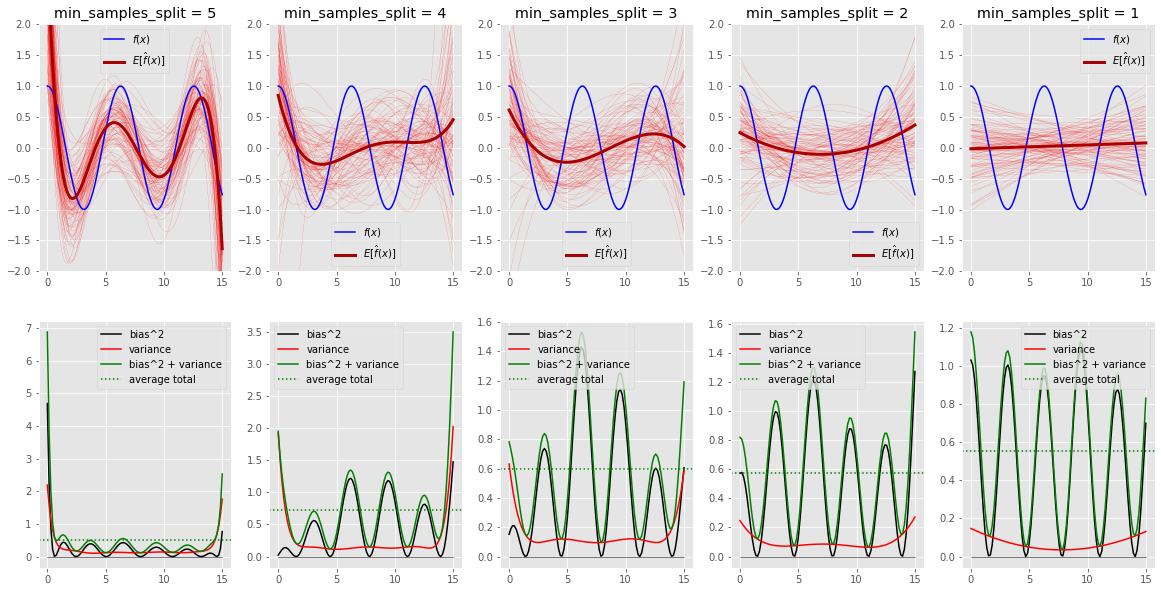

In [158]:
fig = plt.figure(figsize=(20, 10))

bvr.plot(fig=fig,
         base_model=lambda k: Pipeline(steps=[('poly', PolynomialFeatures(k)),
                                              ('lr', LinearRegression())]),
         values=(5, 4, 3, 2, 1),
         label="min_samples_split = {}")

In [10]:
# note: we should really pass in xpts and ypts. Or make this a class

def plot_bias_variance(ax1, ax2, model, x_samples, label):
    n_trials = x_samples.shape[1]
    predictions = np.zeros((n_trials, n_pts))
    for t in range(n_trials):
        x_sample = x_samples[:, t]
        y_sample = y(x_sample)
        model.fit(x_sample[:, None], y_sample)
        predictions[t, :] = model.predict(xpts[:, None])
        ax1.plot(xpts, predictions[t,:], 'r-', lw=0.1)
    ax1.plot(xpts, ypts, 'b-', label='$f(x)$')
    ax1.plot(xpts, predictions.mean(axis=0), color='#AA0000', lw=3, label="$E[\hat f(x)]$")

    ax1.set_ylim((-2, 2))
    ax1.set_title(label)
    ax1.legend()
    #ax[1].plot(xpts, predictions.mean(axis=0) - ypts, 'k', label='bias')
    bias = predictions.mean(axis=0) - ypts
    variance = predictions.var(axis=0)
    error = predictions.mean(axis=0)
    ax2.plot(xpts, bias**2, 'k', label='bias^2')
    ax2.plot(xpts, variance, 'r', label='variance')
    ax2.plot(xpts, bias**2 + variance, 'g', label='bias^2 + variance')
    ax2.plot(xpts, bias**2 + variance, 'g', label='total')
    ax2.plot(xpts, np.zeros_like(xpts), 'k', lw=0.5)
    ax2.axhline(np.mean(bias**2 + variance), color='g', ls=':', label='average total')

    ax2.legend()

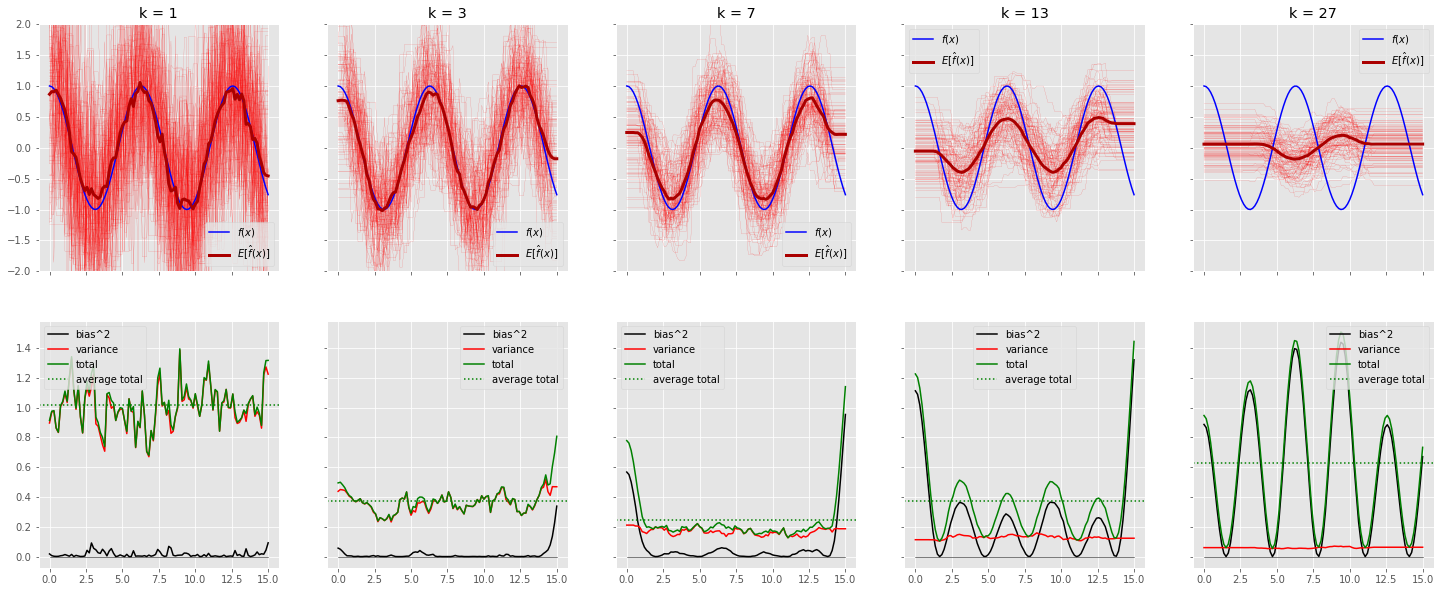

In [13]:
fig, axs = plt.subplots(2, 5, figsize=(25,10), sharey='row', sharex='all')

n_trials = 100
sample_size = 50
x_samples = stats.uniform(xlim[0], xlim[1]-xlim[0]).rvs((sample_size, n_trials))
for i, k in enumerate((1, 3, 7, 13, 27)):
    model = KNeighborsRegressor(k)
    plot_bias_variance(axs[0, i], axs[1, i], model, x_samples, label=f"k = {k}")

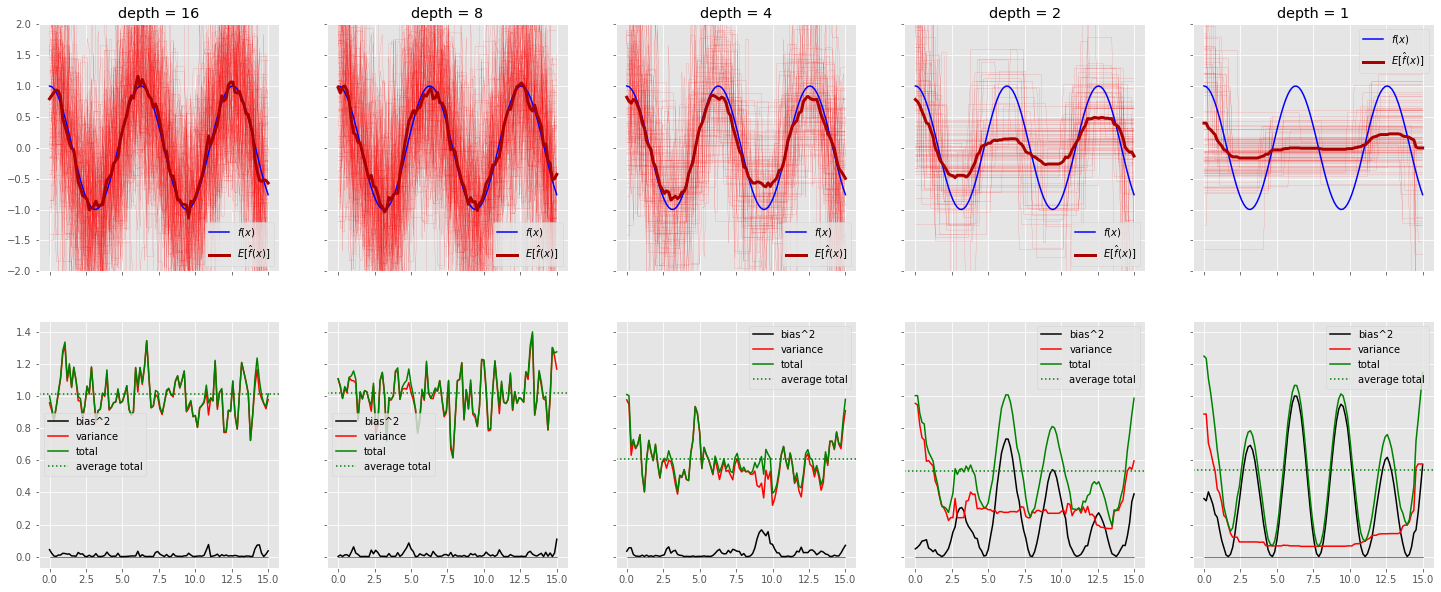

In [10]:
fig, axs = plt.subplots(2, 5, figsize=(25,10), sharey='row', sharex='all')

n_trials = 100
sample_size = 50
x_samples = stats.uniform(xlim[0], xlim[1]-xlim[0]).rvs((sample_size, n_trials))
for i, depth in enumerate((16, 8, 4, 2, 1)):
    model = DecisionTreeRegressor(max_depth=depth)
    plot_bias_variance(axs[0, i], axs[1, i], model, x_samples, label=f"depth = {depth}")

Interesting. It looks as if it's hard to to better than a depth-1 tree. Let's try a different hyperparameter.

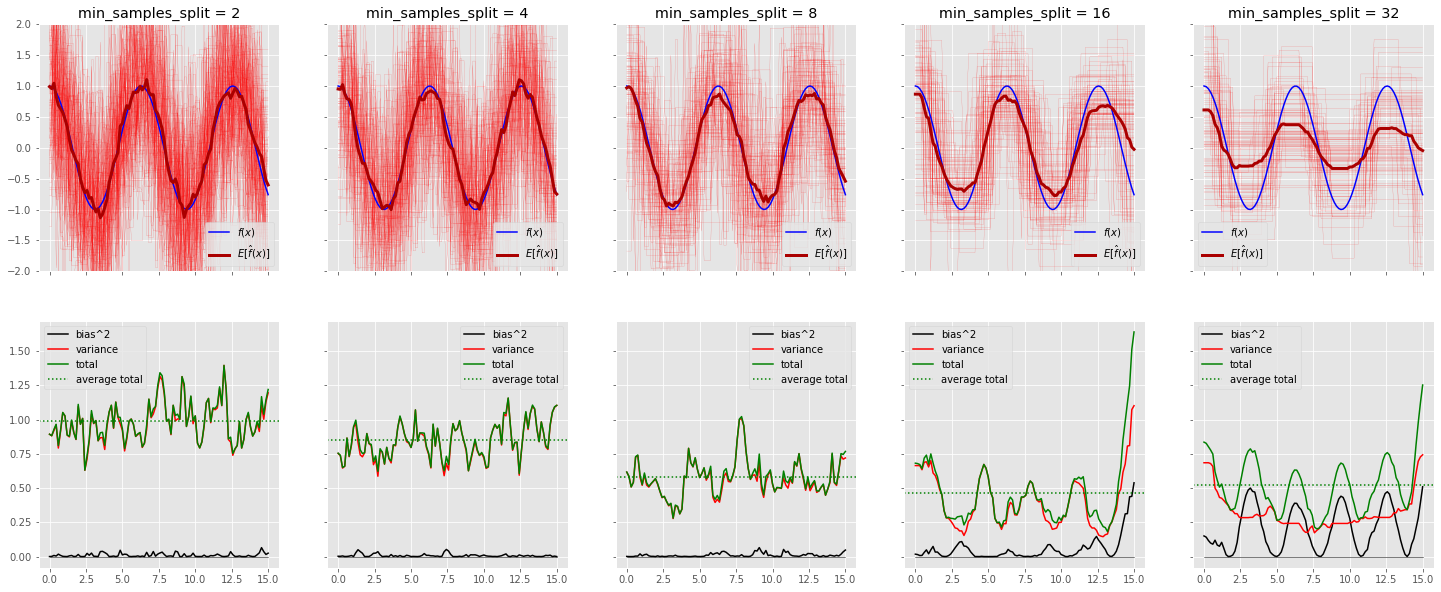

In [14]:
fig, axs = plt.subplots(2, 5, figsize=(25,10), sharey='row', sharex='all')

n_trials = 100
sample_size = 50
x_samples = stats.uniform(xlim[0], xlim[1]-xlim[0]).rvs((sample_size, n_trials))
for i, min_samples_split in enumerate((2, 4, 8, 16, 32)):
    model = DecisionTreeRegressor(min_samples_split=min_samples_split)
    plot_bias_variance(axs[0, i], axs[1, i], model, x_samples, label=f"min_samples_split = {min_samples_split}")

That one seems better.

Now let's try polynomial models.

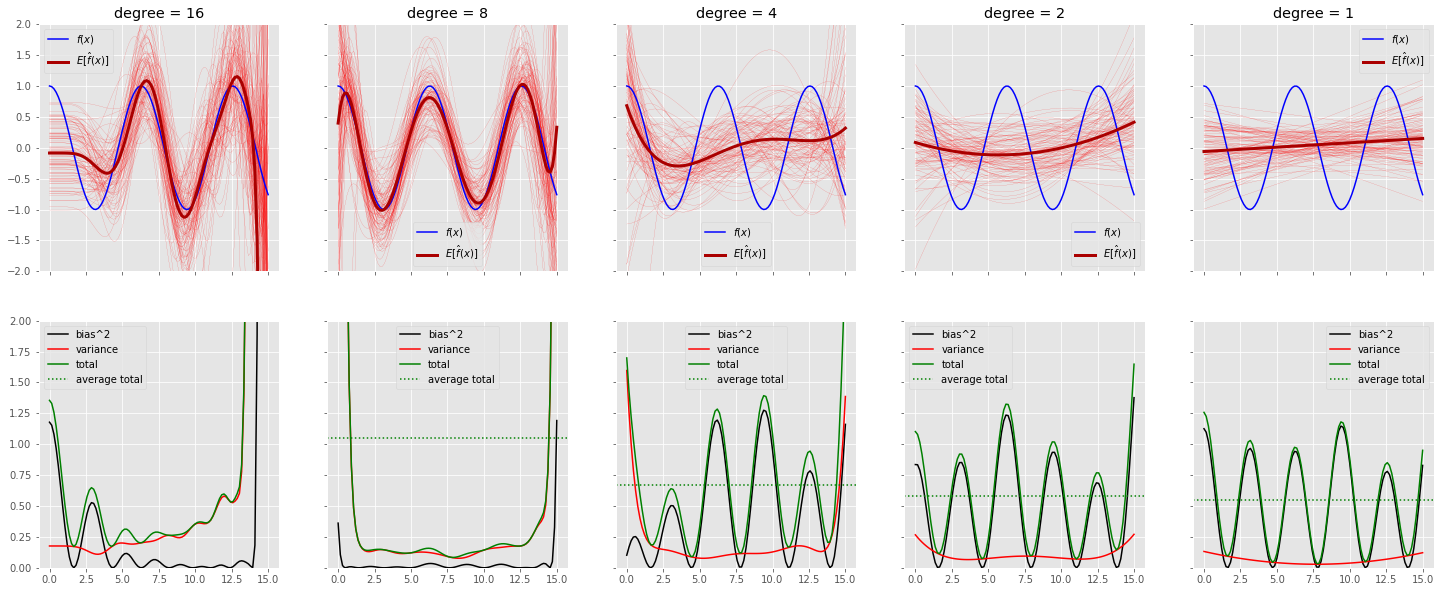

In [12]:
fig, axs = plt.subplots(2, 5, figsize=(25,10), sharey='row', sharex='all')

# limit y on the lower graph, because things blow up
axs[1, 0].set_ylim(0, 2)

n_trials = 100
sample_size = 50
x_samples = stats.uniform(xlim[0], xlim[1]-xlim[0]).rvs((sample_size, n_trials))
for i, degree in enumerate((16, 8, 4, 2, 1)):
    model = Pipeline(steps=[('poly', PolynomialFeatures(degree)),
                            ('lr', LinearRegression())])
    plot_bias_variance(axs[0, i], axs[1, i], model, x_samples, label=f"degree = {degree}")

One might have expected that the a polynomial of sufficiently high degree would be a great way to predict a cosine. And the total of bias and variance at degree = 8 is really low...except at either end. It's so bad there, it makes the overall average worse than lower orders.

Polynomial regression: not so great.

Let's try it again with Ridge regression, changing $\alpha$, using a degree-five polynomial.

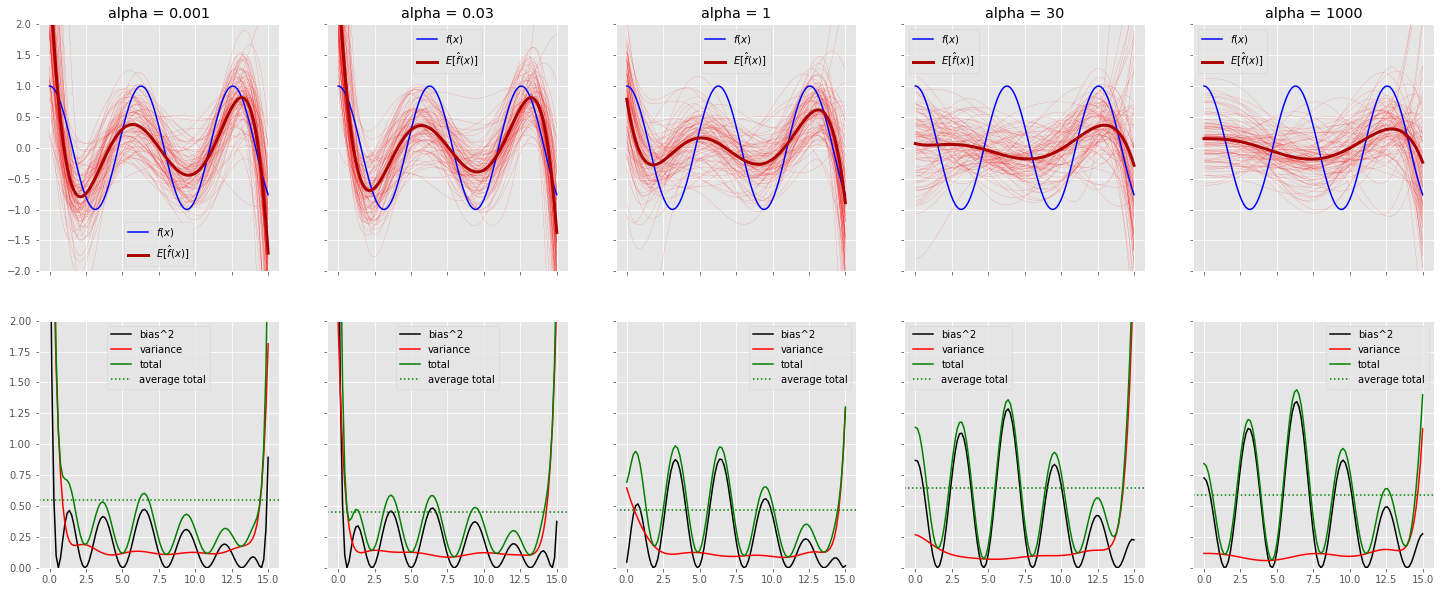

In [18]:
fig, axs = plt.subplots(2, 5, figsize=(25,10), sharey='row', sharex='all')

# limit y on the lower graph, because things blow up
axs[1, 0].set_ylim(0, 2)
n_trials = 100
sample_size = 50
x_samples = stats.uniform(xlim[0], xlim[1]-xlim[0]).rvs((sample_size, n_trials))
for i, alpha in enumerate((0.001, 0.03, 1, 30, 1000)):
    model = Pipeline(steps=[('poly', PolynomialFeatures(5)),
                            ('lr', Ridge(alpha=alpha))])
    plot_bias_variance(axs[0, i], axs[1, i], model, x_samples, label=f"alpha = {alpha}")

It's not a big difference.